In [1]:
from sen12ms.dataset import sen12ms

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
dataset = sen12ms("/mnt/data")

In [4]:
image, label = dataset[100]

In [5]:
from albumentations import (
    Compose, ToFloat, FromFloat, RandomRotate90, Flip, OneOf, MotionBlur, MedianBlur, Blur,
    ShiftScaleRotate, OpticalDistortion, GridDistortion, RandomBrightnessContrast,
    HueSaturationValue, Resize,GaussNoise, ImageOnlyTransform, Rotate, ElasticTransform
)

from albumentations.core.composition import BaseCompose

import cv2

In [6]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    
    # Woodlands
    color_list[0] = [0.14509804, 0.34117647, 0.04705882,1]
    color_list[1] = [0.14509804, 0.34117647, 0.04705882,1]
    color_list[2] = [0.14509804, 0.34117647, 0.04705882,1]
    color_list[3] = [0.14509804, 0.34117647, 0.04705882,1]
    color_list[4] = [0.14509804, 0.34117647, 0.04705882,1]
    
    color_list[6] = [1,0.702,0,1] #shrub
    color_list[7] = [1,0.702,0,1] #shrub
    
    color_list[9] = [1., 0.97254902, 0.45098039, 1] #woody savannah
    color_list[8] = [0.10588235, 0.50980392, 0.14901961, 1] #savannah
    
    color_list[10] = [0.83137255, 1., 0.76078431,1]  #grassland
    color_list[11] = [0.55294118, 0.94117647, 0.8,1] #wetland
    
    color_list[12] = [0.54509804, 1, 0.52156863,1] # Cropland
    color_list[13] = [0.4,0.4,0.4,1] # Urban
    color_list[14] = [0.54509804, 1, 0.52156863,1] # Cropland
    
    color_list[15] = [0.6784,0.9137,1,1] # Ice
    color_list[16] = [0.3,0.19,0.0078,1] # Barren
    color_list[17] = [0,0.4156,0.7607,1] # Water
    
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [7]:
def plot_augmentation(dataset, composer, channels=(4,3,2), plot_segmentation=True):
    image, label = dataset[random.randint(len(dataset))]
    ch_segmentation =np.argmax(label.numpy(), 0)
    
    augmented = composer(image=image.numpy().transpose((1,2,0)), mask=ch_segmentation)
    discrete_cm = discrete_cmap(18, 'jet_r')
    
    if plot_segmentation:
        plt.figure(figsize=(10,10))
        plt.subplot(221)
        plt.imshow(image[channels,:,:].numpy().transpose((1,2,0))*4096/3200)
        plt.subplot(222)
        plt.imshow(augmented['image'][:,:,channels]*4096/3200)
        plt.subplot(223)
        plt.imshow(ch_segmentation, cmap=discrete_cm, vmin=0, vmax=18)
        plt.subplot(224)
        plt.imshow(augmented['mask'], cmap=discrete_cm, vmin=0, vmax=18)
    else:
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plt.imshow(image[channels,:,:].numpy().transpose((1,2,0))*4096/3200)
        plt.subplot(122)
        plt.imshow(augmented['image'][:,:,channels]*4096/3200)

In [8]:
class PerChannel(BaseCompose):
    """Apply transformations per-channel

    Args:
        transforms (list): list of transformations to compose.
        channels (list): channels to apply the transform to. Pass None to apply to all.
                         Default: None (apply to all)
        p (float): probability of applying the transform. Default: 0.5.
    """

    def __init__(self, transforms, channels=None, p=0.5):
        super(PerChannel, self).__init__(transforms, p)
        self.transforms = transforms
        self.channels = channels

    def __call__(self, force_apply=False, **data): 
        
        image = data['image']
        
        # Mono images
        if len(image.shape) == 2:
            image = np.expand_dims(image, -1)

        if self.channels is None:
            self.channels = range(image.shape[2])

        for c in self.channels:
            for t in self.transforms:
                image[:,:,c] = t(image=image[:,:,c])['image']

        data['image'] = image
            
        return data

Flip:

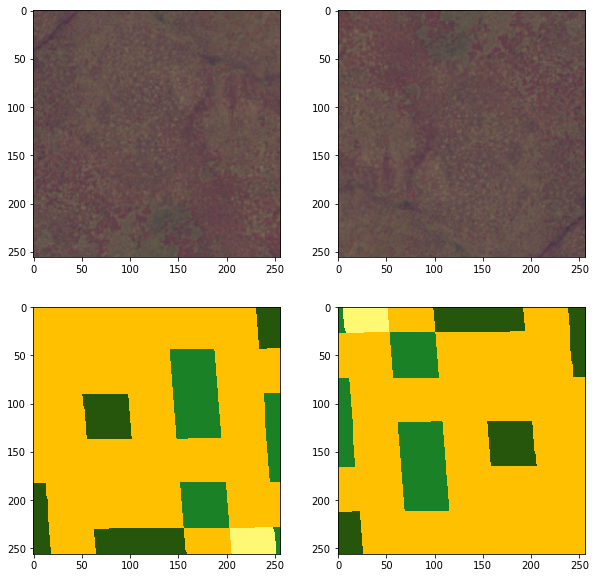

In [9]:
plot_augmentation(dataset, Compose([ToFloat(), Flip(always_apply=True)]))

Motion blur

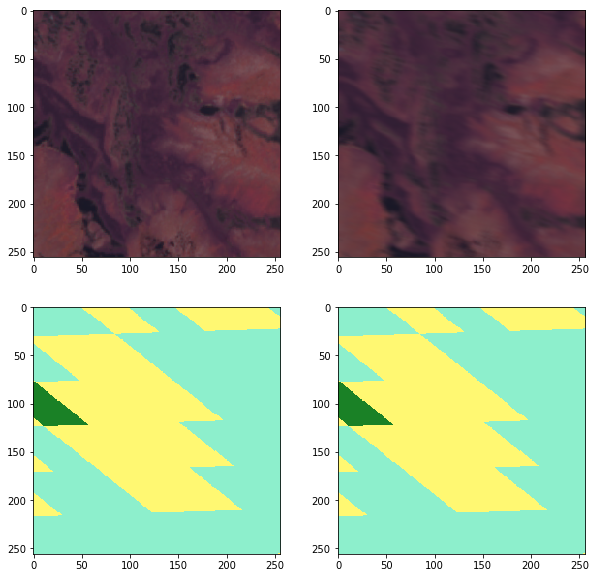

In [10]:
plot_augmentation(dataset, Compose([ToFloat(), MotionBlur(40, always_apply=True)]))

Downsample (resize)

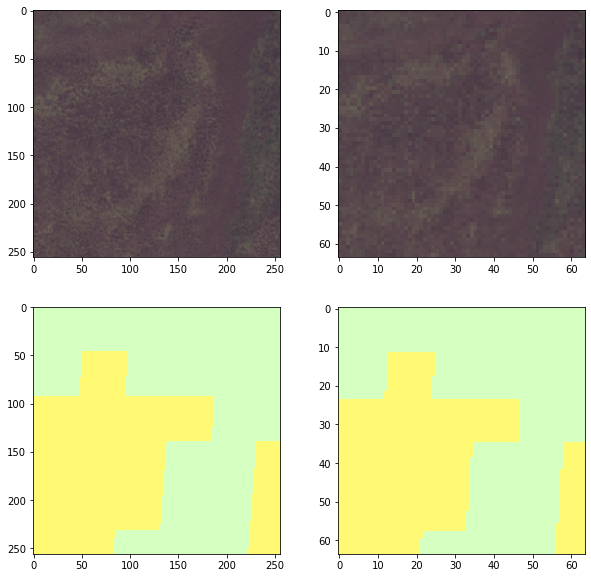

In [11]:
plot_augmentation(dataset, Compose([ToFloat(), Resize(width=64, height=64)]))

Shift, scale and rotate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


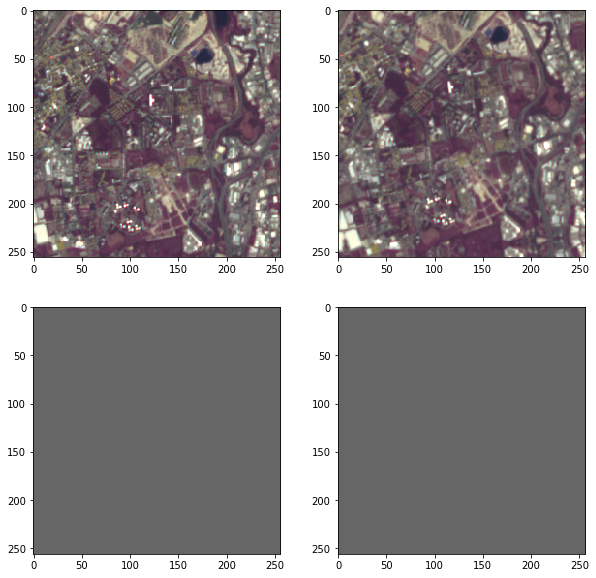

In [12]:
plot_augmentation(dataset, Compose([ToFloat(), ShiftScaleRotate(always_apply=True)]))

Gaussian Noise

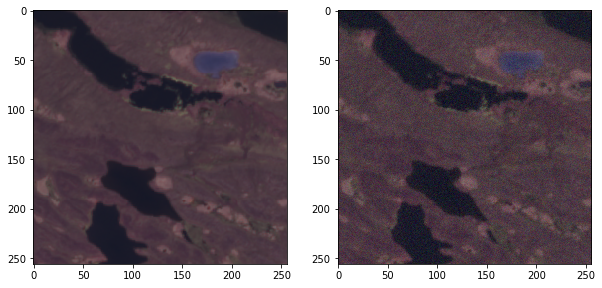

In [13]:
plot_augmentation(dataset, Compose([ToFloat(), GaussNoise(var_limit=(1e-5, 1e-3), always_apply=True)]), plot_segmentation=False)

Brightness/Contrast

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


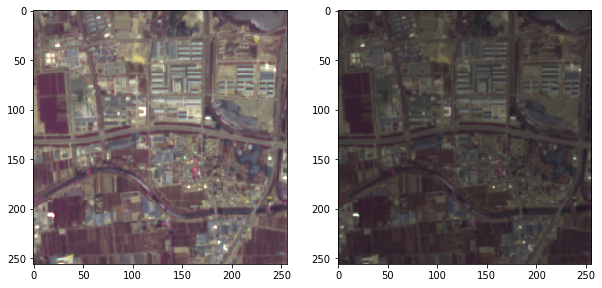

In [14]:
plot_augmentation(dataset, Compose([ToFloat(),
                                    RandomBrightnessContrast(brightness_limit=0.8, contrast_limit=0.8, always_apply=True)]), plot_segmentation=False)

Inter-channel jitter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


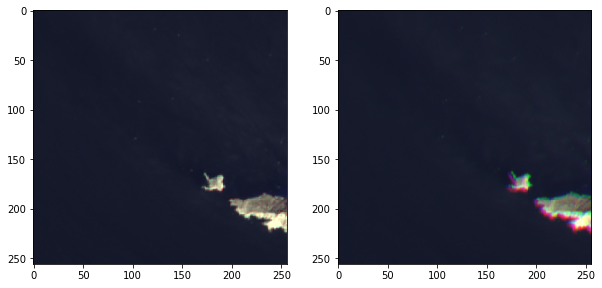

In [15]:
jitter = ShiftScaleRotate(shift_limit=0.01, scale_limit=0.01, rotate_limit=0.01, always_apply=True)

plot_augmentation(dataset, Compose([ToFloat(),
                                    PerChannel([jitter])]), plot_segmentation=False)

Elastic transformation (location dependent)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


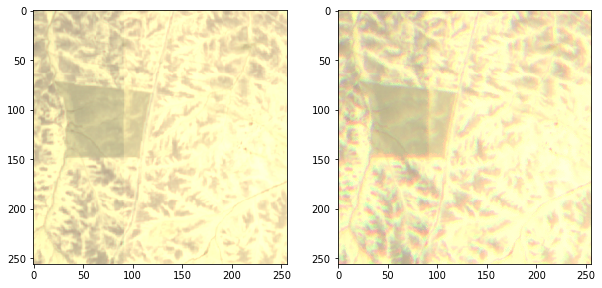

In [16]:
jitter = ElasticTransform(alpha_affine=4, sigma=0.002)

plot_augmentation(dataset, Compose([ToFloat(),
                                    PerChannel([jitter])]), plot_segmentation=False)

Example of multiple transforms:

In [17]:
channel_jitter = ShiftScaleRotate(shift_limit=0.001, scale_limit=0.01, rotate_limit=0.01, always_apply=True)

augmentation = Compose([ToFloat(),
    PerChannel([channel_jitter]),
    GaussNoise(var_limit=(1e-6, 1e-3),p=0.2),
    MotionBlur(3),
    Flip(),
    ShiftScaleRotate()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


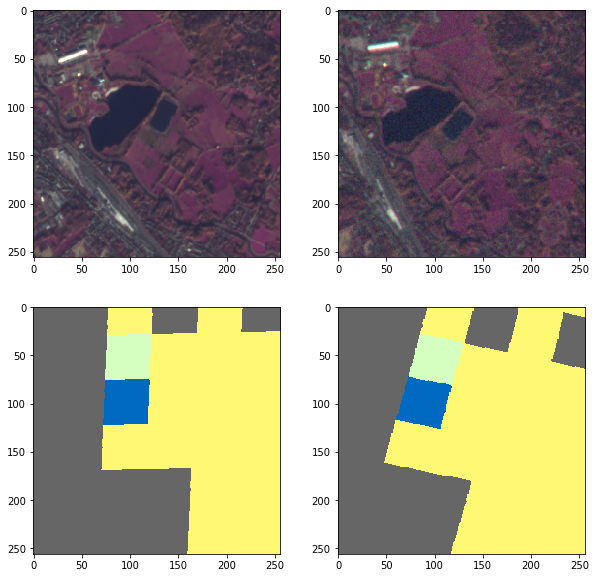

In [18]:
plot_augmentation(dataset, augmentation, plot_segmentation=True)